### import & get data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown --id 1-FH5h2JCQ1h6DYivh9b0lgUNFwGt1s4r
!unzip data.zip

In [8]:
%cd /content/drive/MyDrive/Work_Share/Pix2Pix_Denoising_and_Super_Resolution

/content/drive/.shortcut-targets-by-id/1hPMA1K_LEbWgkW44gTVTTTPj3cDkZEIY/Work_Share/GAN


In [4]:
import tensorflow as tf
from utils.utils import load, normalize, random_jitter, load_image_train, load_image_test, evaluate, generate_images
from utils.loss import generator_denoise_loss, generator_sr_loss, discriminator_loss
from models.generator import Generator
from models.discriminator import DiscriminatorDenoise, DiscriminatorSR
import os
import cfg
print(tf.__version__)

2.12.0


### dataset & model

In [5]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(cfg.data_train)

train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(cfg.buffer_size)
train_dataset = train_dataset.batch(1)

# test_dataset
test_dataset = tf.data.Dataset.list_files(cfg.data_test)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

generator = Generator()
discriminator1 = DiscriminatorDenoise()
discriminator2 = DiscriminatorSR()

generator_optimizer     = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator1_optimizer = tf.keras.optimizers.Adam(7e-3, beta_1=0.5)
discriminator2_optimizer = tf.keras.optimizers.Adam(7e-3, beta_1=0.5)

checkpoint_dir = cfg.checkpoint_dir
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator1_optimizer=discriminator1_optimizer,
                                discriminator2_optimizer=discriminator2_optimizer,
                                generator=generator,
                                discriminator1=discriminator1,
                                discriminator2=discriminator2)

### training

In [ ]:
@tf.function
def train_step(image_lr, target_lr, target_hr):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc1_tape, tf.GradientTape() as disc2_tape:

        fake_lr, fake_hr = generator(image_lr, training=True)

        disc_lr_real_output = discriminator1([image_lr,target_lr], training=True)
        disc_lr_generated_output = discriminator1([image_lr, fake_lr], training=True)

        disc_hr_real_output = discriminator2(target_hr, training=True)
        disc_hr_generated_output = discriminator2(fake_hr, training=True)

        total_lr_loss, gan_lr_loss, l1_lr_loss = generator_denoise_loss(disc_lr_generated_output, fake_lr, target_lr)
        total_hr_loss, gan_hr_loss, l1_hr_loss = generator_sr_loss(disc_hr_generated_output, fake_hr, target_hr)

        disc_lr_loss = discriminator_loss(disc_lr_real_output, disc_lr_generated_output)
        disc_hr_loss = discriminator_loss(disc_hr_real_output, disc_hr_generated_output)

        gan_loss = gan_lr_loss + gan_hr_loss
        l1_loss = l1_lr_loss + l1_hr_loss
        disc_loss = disc_lr_loss + disc_hr_loss

        total_gen_loss = total_lr_loss + total_hr_loss

    gen_gradients = gen_tape.gradient(total_gen_loss, generator.trainable_variables)
    disc1_gradients = disc1_tape.gradient(disc_lr_loss, discriminator1.trainable_variables)
    disc2_gradients = disc2_tape.gradient(disc_hr_loss, discriminator2.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator1_optimizer.apply_gradients(zip(disc1_gradients, discriminator1.trainable_variables))
    discriminator2_optimizer.apply_gradients(zip(disc2_gradients, discriminator2.trainable_variables))

    return gan_loss, l1_loss, disc_loss

def fit(train_ds, epochs, test_ds):
    best_psnr = 0.0
    for epoch in range(epochs):

        for image_lr, target_lr, target_hr in train_ds:
            gan_loss, l1_loss, disc_loss = train_step(image_lr, target_lr, target_hr)

        psnr = evaluate(generator, epoch, test_ds)
        if best_psnr < psnr:
            checkpoint.save(file_prefix = checkpoint_prefix)
            best_psnr = psnr

            for image_lr, target_lr, target_hr in test_ds.take(1):
                generate_images(generator, image_lr, target_hr)

        print('epoch {}  gan_loss: {}  l1_loss: {}  disc_loss: {}'.format(epoch, gan_loss, l1_loss, disc_loss))

-------- psnr:  2.9631846    ----- epoch:  0


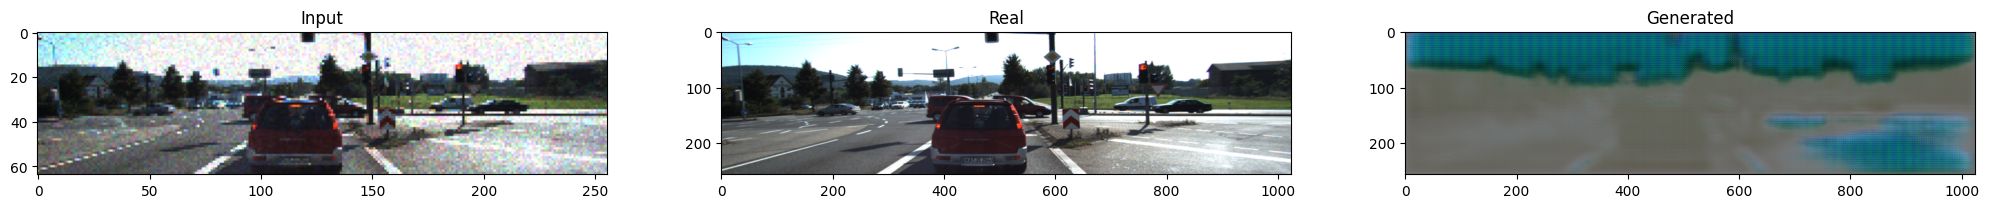

epoch 0  gan_loss: 2.84346079826355  l1_loss: 0.8436886668205261  disc_loss: 6.724038124084473
-------- psnr:  13.8106575    ----- epoch:  1


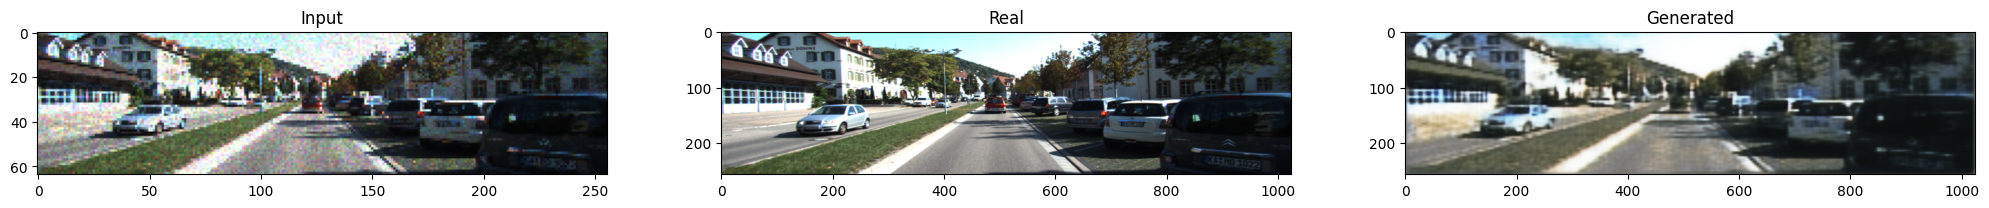

epoch 1  gan_loss: 1.382421612739563  l1_loss: 0.22862458229064941  disc_loss: 2.7719812393188477
-------- psnr:  14.628769    ----- epoch:  2


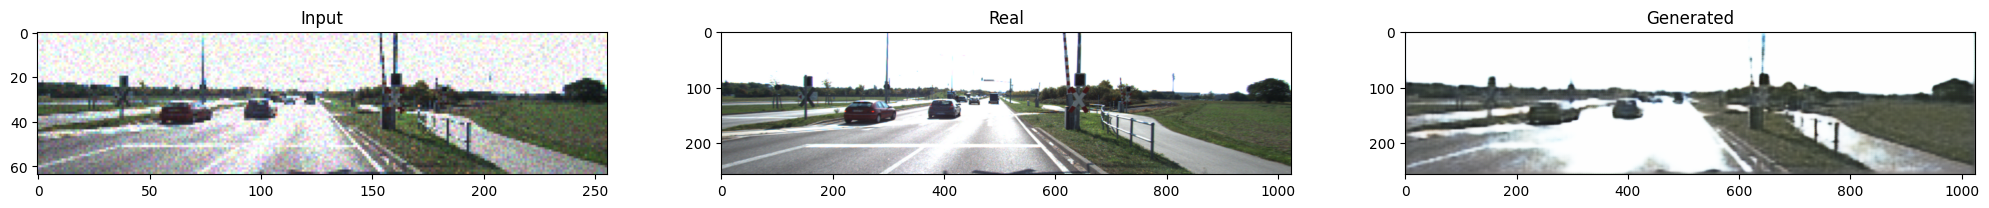

epoch 2  gan_loss: 1.3480193614959717  l1_loss: 0.1642749160528183  disc_loss: 2.7818069458007812
-------- psnr:  14.636316    ----- epoch:  3


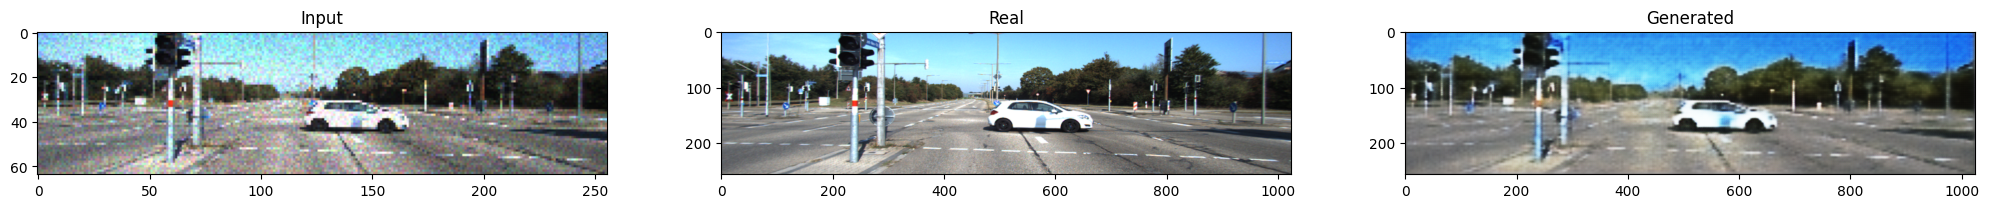

epoch 3  gan_loss: 1.4689265489578247  l1_loss: 0.26255667209625244  disc_loss: 2.7739481925964355
-------- psnr:  15.908668    ----- epoch:  4


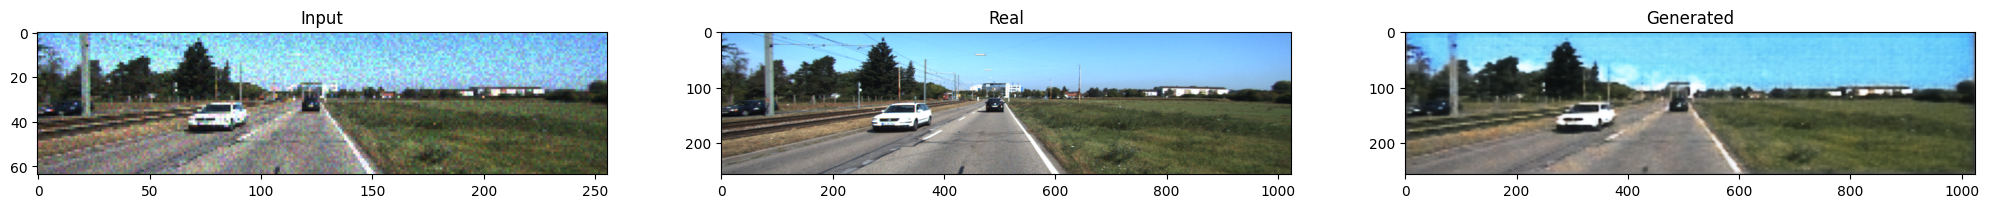

epoch 4  gan_loss: 1.4390748739242554  l1_loss: 0.19703532755374908  disc_loss: 2.779897689819336
-------- psnr:  16.548845    ----- epoch:  5


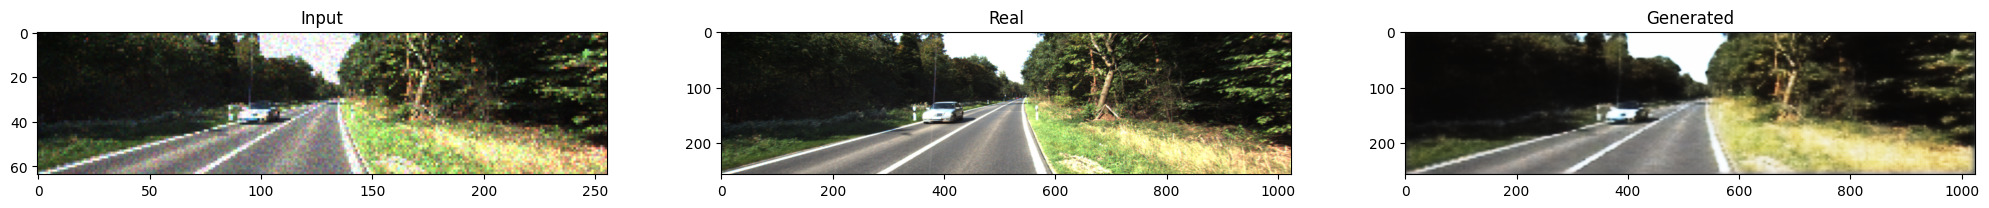

epoch 5  gan_loss: 1.3448506593704224  l1_loss: 0.20918405055999756  disc_loss: 2.7505125999450684
-------- psnr:  16.114952    ----- epoch:  6
epoch 6  gan_loss: 1.4185547828674316  l1_loss: 0.15606144070625305  disc_loss: 2.7778143882751465
-------- psnr:  14.305317    ----- epoch:  7
epoch 7  gan_loss: 1.3922674655914307  l1_loss: 0.17955520749092102  disc_loss: 2.7930984497070312
-------- psnr:  17.588596    ----- epoch:  8


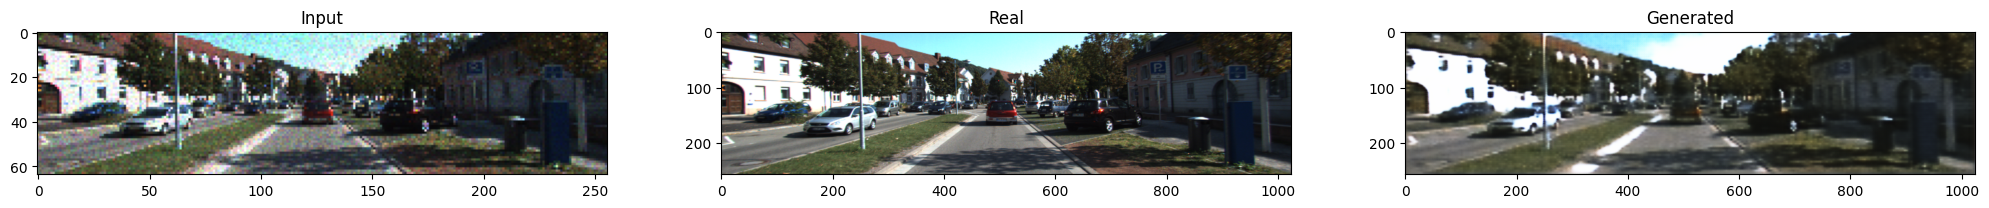

epoch 8  gan_loss: 1.3946561813354492  l1_loss: 0.13900259137153625  disc_loss: 2.7751636505126953
-------- psnr:  17.008919    ----- epoch:  9
epoch 9  gan_loss: 1.3916751146316528  l1_loss: 0.182307168841362  disc_loss: 2.769230842590332
-------- psnr:  16.265041    ----- epoch:  10
epoch 10  gan_loss: 1.3176679611206055  l1_loss: 0.18041497468948364  disc_loss: 2.773444890975952
-------- psnr:  17.085796    ----- epoch:  11
epoch 11  gan_loss: 1.4004967212677002  l1_loss: 0.19944119453430176  disc_loss: 2.7849929332733154
-------- psnr:  15.856507    ----- epoch:  12
epoch 12  gan_loss: 1.3861641883850098  l1_loss: 0.16128842532634735  disc_loss: 2.7681374549865723
-------- psnr:  17.341768    ----- epoch:  13
epoch 13  gan_loss: 1.4100217819213867  l1_loss: 0.18457382917404175  disc_loss: 2.722954750061035
-------- psnr:  15.387936    ----- epoch:  14
epoch 14  gan_loss: 1.3961644172668457  l1_loss: 0.14404237270355225  disc_loss: 2.773791790008545
-------- psnr:  11.529208    ----

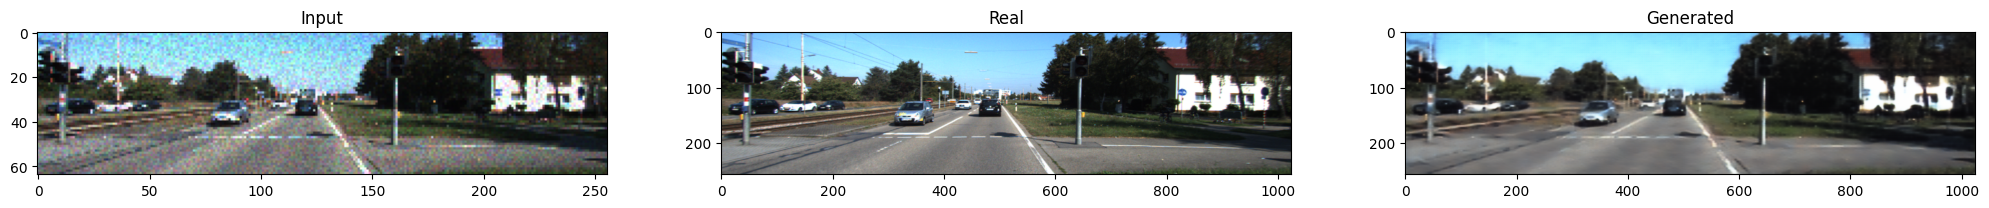

epoch 45  gan_loss: 1.37904691696167  l1_loss: 0.16312754154205322  disc_loss: 2.772982597351074
-------- psnr:  18.239511    ----- epoch:  46
epoch 46  gan_loss: 1.3989828824996948  l1_loss: 0.10820870101451874  disc_loss: 2.777101993560791
-------- psnr:  16.931448    ----- epoch:  47
epoch 47  gan_loss: 1.370161771774292  l1_loss: 0.1468230038881302  disc_loss: 2.7688467502593994
-------- psnr:  17.669313    ----- epoch:  48
epoch 48  gan_loss: 1.4529602527618408  l1_loss: 0.140684574842453  disc_loss: 2.777468204498291
-------- psnr:  17.971357    ----- epoch:  49
epoch 49  gan_loss: 1.4020627737045288  l1_loss: 0.12023837864398956  disc_loss: 2.77864933013916
-------- psnr:  17.013931    ----- epoch:  50
epoch 50  gan_loss: 1.3739230632781982  l1_loss: 0.16419389843940735  disc_loss: 2.7785544395446777
-------- psnr:  13.81299    ----- epoch:  51
epoch 51  gan_loss: 1.4072980880737305  l1_loss: 0.15910497307777405  disc_loss: 2.767983913421631
-------- psnr:  17.269026    ----- ep

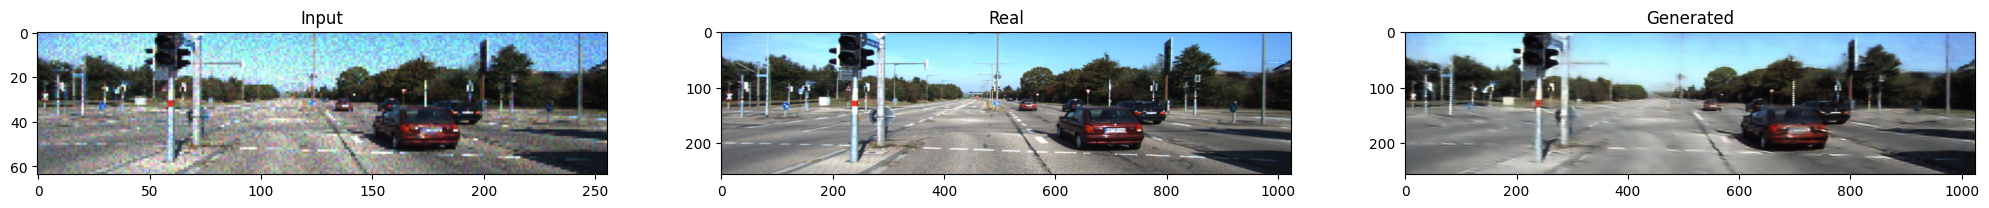

epoch 80  gan_loss: 1.8174635171890259  l1_loss: 0.12930117547512054  disc_loss: 2.9645261764526367
-------- psnr:  15.496939    ----- epoch:  81
epoch 81  gan_loss: 1.4271886348724365  l1_loss: 0.11336483061313629  disc_loss: 2.675497531890869
-------- psnr:  16.59567    ----- epoch:  82
epoch 82  gan_loss: 1.362718939781189  l1_loss: 0.1683584302663803  disc_loss: 2.7251667976379395
-------- psnr:  15.429744    ----- epoch:  83
epoch 83  gan_loss: 1.4911197423934937  l1_loss: 0.14754770696163177  disc_loss: 2.7122507095336914
-------- psnr:  15.953145    ----- epoch:  84
epoch 84  gan_loss: 1.421266794204712  l1_loss: 0.15012285113334656  disc_loss: 2.7322373390197754
-------- psnr:  16.70119    ----- epoch:  85
epoch 85  gan_loss: 1.3809316158294678  l1_loss: 0.16948875784873962  disc_loss: 2.77042555809021
-------- psnr:  16.82833    ----- epoch:  86
epoch 86  gan_loss: 1.3864355087280273  l1_loss: 0.15070553123950958  disc_loss: 2.7289938926696777
-------- psnr:  16.267385    ----

In [ ]:
epochs = 120
fit(train_dataset, epochs, test_dataset)

### save weight

In [ ]:
latest = tf.train.latest_checkpoint(cfg.checkpoint_dir)
checkpoint.restore(latest)

In [ ]:
generator.save_weights('/content/drive/MyDrive/Work_Share/Pix2Pix_Denoising_and_Super_Resolution/weights/generator.h5')

### predict

In [6]:
generator.load_weights('/content/drive/MyDrive/Work_Share/Pix2Pix_Denoising_and_Super_Resolution/weights/generator.h5')

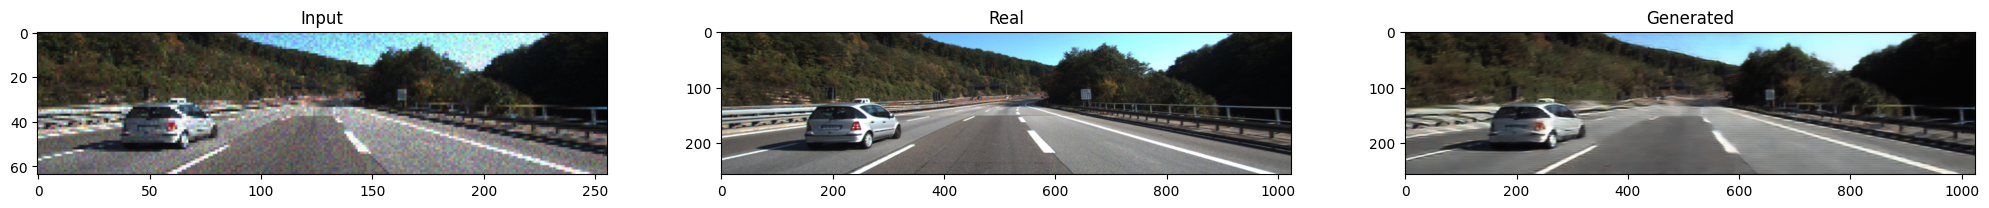

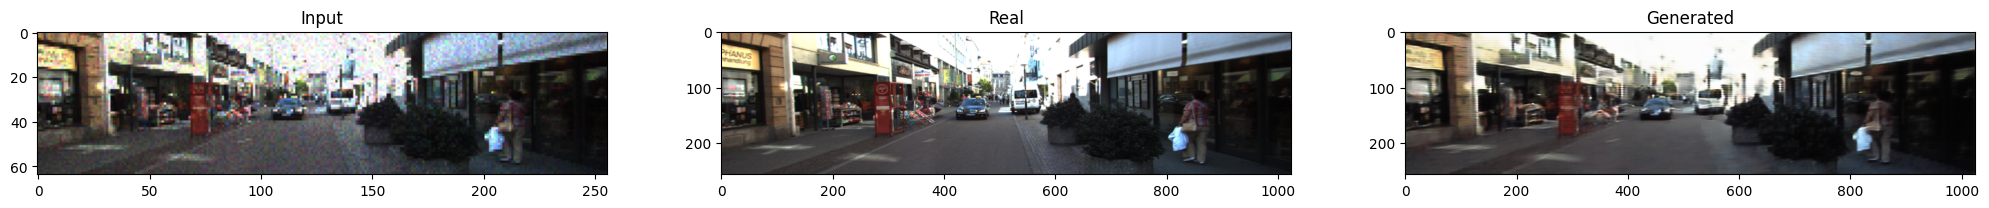

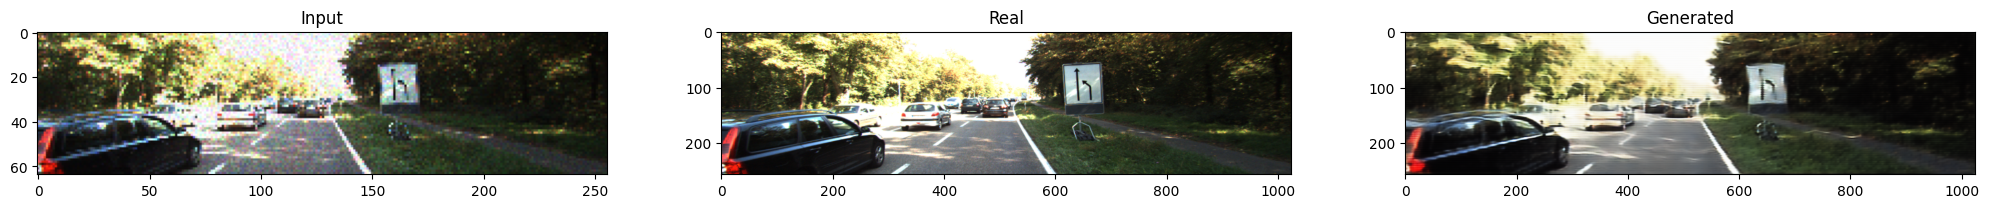

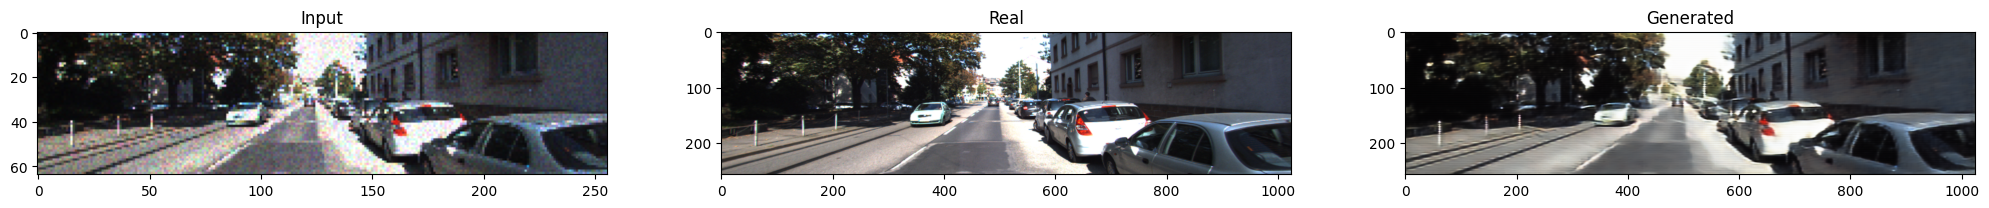

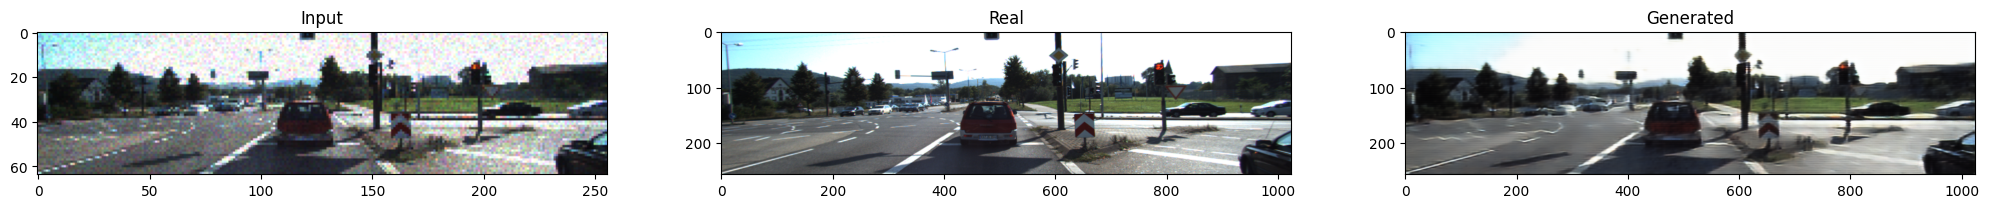

In [7]:
for image_lr, target_lr, target_hr in test_dataset.take(5):
    generate_images(generator, image_lr, target_hr, is_fake_lr=False)